In [1]:
import os 
import pandas as pd
from sklearn.preprocessing import StandardScaler
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import re
warnings.filterwarnings('ignore')

In [2]:
# === CONFIG ===
TEST_SUBJECT = "S4"  # test on S4; train on the rest
DATA_DIR = Path(r"./OpportunityUCIDataset/dataset")  # change this to your .dat directory
OUT_DIR  = Path(r".")
def get_index(string):
    """
    Helper function to extract the index from a line.
    get the index of the first alphabet in the string after the 9th index

    Args:
    line (str): Input line containing index information.

    Returns:
    int: Extracted index.
    """

    for i in range(9,len(string)):
        if string[i].isalpha():
            return i
    return -1
names_file = DATA_DIR.parent / "column_names.txt"   # adjust if different name
with open(os.path.join(DATA_DIR, "column_names.txt"), 'r') as f:
    lines = f.read().splitlines()
    columns = []
    for line in lines:
        if 'Column' in line:
            # Extract column names and append to the list
            columns.append(line[get_index(line):].split(";")[0])

In [ ]:
READ_KW = dict(
    sep=r"\s+",
    header=None,
    engine="python",
    na_values=["NaN", "nan"]
)

all_files = sorted(DATA_DIR.glob("S*-*.dat"))
train_files = [f for f in all_files if not f.name.startswith(TEST_SUBJECT)]
test_files  = [f for f in all_files if f.name.startswith(TEST_SUBJECT)]

print("Train files:", [f.name for f in train_files])
print("Test files:", [f.name for f in test_files])

# Determine number of columns
n_cols = pd.read_csv(train_files[0], nrows=1, **READ_KW).shape[1]

# Read & concat
train_df = pd.concat([pd.read_csv(f, **READ_KW) for f in train_files], ignore_index=True)
test_df  = pd.concat([pd.read_csv(f, **READ_KW) for f in test_files], ignore_index=True)

# Sanity check
assert train_df.shape[1] == n_cols
assert test_df.shape[1] == n_cols

# Save
train_path = OUT_DIR / "train.csv"
test_path  = OUT_DIR / "test.csv"
train_df.columns = columns
test_df.columns = columns
train_df.to_csv(train_path, index=False, header=False)
test_df.to_csv(test_path,  index=False, header=False)

print(f"Saved train.csv ({len(train_df):,} rows), test.csv ({len(test_df):,} rows)")

Train files: ['S1-ADL1.dat', 'S1-ADL2.dat', 'S1-ADL3.dat', 'S1-ADL4.dat', 'S1-ADL5.dat', 'S1-Drill.dat', 'S2-ADL1.dat', 'S2-ADL2.dat', 'S2-ADL3.dat', 'S2-ADL4.dat', 'S2-ADL5.dat', 'S2-Drill.dat', 'S3-ADL1.dat', 'S3-ADL2.dat', 'S3-ADL3.dat', 'S3-ADL4.dat', 'S3-ADL5.dat', 'S3-Drill.dat']
Test files: ['S4-ADL1.dat', 'S4-ADL2.dat', 'S4-ADL3.dat', 'S4-ADL4.dat', 'S4-ADL5.dat', 'S4-Drill.dat']
Saved train.csv (676,713 rows), test.csv (192,674 rows)


In [ ]:
train_df.columns = columns
test_df.columns = columns

In [5]:
na_counts = train_df.isna().mean().sort_values(ascending=False) * 100
print(na_counts)
row_na_counts = train_df.isna().mean(axis=1).sort_values(ascending=False) * 100
print(row_na_counts)

Accelerometer RH accZ    57.986621
Accelerometer RH accY    57.986621
Accelerometer RH accX    57.986621
Accelerometer LH accZ    13.282588
Accelerometer LH accY    13.282588
                           ...    
LL_Left_Arm               0.000000
LL_Left_Arm_Object        0.000000
LL_Right_Arm              0.000000
LL_Right_Arm_Object       0.000000
ML_Both_Arms              0.000000
Length: 250, dtype: float64
524841    95.6
524848    95.6
524833    95.6
524834    95.6
524819    95.6
          ... 
480938     0.0
480939     0.0
480940     0.0
480941     0.0
480942     0.0
Length: 676713, dtype: float64


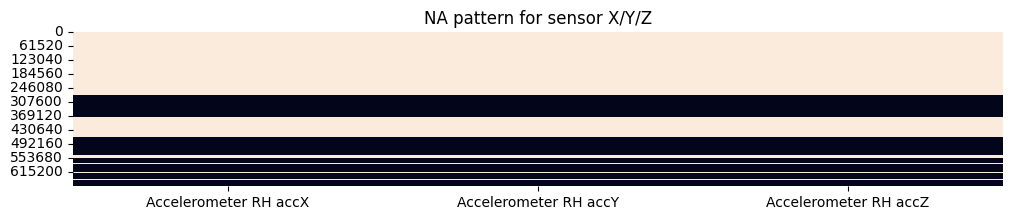

In [6]:
plt.figure(figsize=(12,2))
sns.heatmap(train_df[["Accelerometer RH accX","Accelerometer RH accY","Accelerometer RH accZ"]].isna(), cbar=False)
plt.title("NA pattern for sensor X/Y/Z")
plt.show()

In [8]:
def uniquify_columns(columns):
    seen = {}
    out = []
    for c in columns:
        if c not in seen:
            seen[c] = 0
            out.append(c)
        else:
            seen[c] += 1
            out.append(f"{c}__dup{seen[c]}")
    return out

if train_df.columns.duplicated().any():
    df = train_df.copy()
    train_df.columns = uniquify_columns(df.columns)
if test_df.columns.duplicated().any():
    df = test_df.copy()
    test_df.columns = uniquify_columns(df.columns)


In [9]:
window = 5 
num_cols = train_df.select_dtypes(include="number").columns
train_df[num_cols] = train_df[num_cols].apply(
    lambda col: col.fillna(col.rolling(window, min_periods=1, center=True).mean())
)
test_df[num_cols] = test_df[num_cols].apply(
    lambda col: col.fillna(col.rolling(window, min_periods=1, center=True).mean())
)

In [10]:
for col in train_df.columns:
    train_df[col] = train_df[col].interpolate(method="linear").fillna(method="bfill").fillna(method="ffill")
    test_df[col] = test_df[col].interpolate(method="linear").fillna(method="bfill").fillna(method="ffill")


In [ ]:
scaler = StandardScaler()
train_df[train_df.columns[:-7]] = scaler.fit_transform(train_df[train_df.columns[:-7]])
test_df[test_df.columns[:-7]] = scaler.transform(test_df[test_df.columns[:-7]])

In [14]:
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path,  index=False)